In [37]:
# CELL 1: Library Imports and Environment Setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Utility and helper modules
import random
import pickle
import warnings
import re
import sys
from tqdm import tqdm
from collections import defaultdict, Counter, deque
from typing import List, Dict, Set, Tuple, Optional

# Suppress unnecessary warnings
warnings.filterwarnings('ignore')

# Fix random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Configure visualization defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")




In [39]:
# CELL 2: Load and Analyze Corpus

def load_corpus(filepath='corpus.txt'):
    """Load and preprocess the word corpus"""
    with open(filepath, 'r') as f:
        words = [line.strip().lower() for line in f if line.strip()]
    
    print(f"Corpus Statistics:")
    print(f"  Total words: {len(words)}")
    
    # Count how many words exist of each length
    length_dist = Counter(len(w) for w in words)
    print(f"\nWord length counts:")
    for length, count in sorted(length_dist.items()):
        print(f"  Length {length}: {count} words")
    
    return words

# Load the corpus
corpus = load_corpus('corpus.txt')


Corpus Statistics:
  Total words: 50000

Word length counts:
  Length 1: 46 words
  Length 2: 84 words
  Length 3: 388 words
  Length 4: 1169 words
  Length 5: 2340 words
  Length 6: 3755 words
  Length 7: 5111 words
  Length 8: 6348 words
  Length 9: 6808 words
  Length 10: 6465 words
  Length 11: 5452 words
  Length 12: 4292 words
  Length 13: 3094 words
  Length 14: 2019 words
  Length 15: 1226 words
  Length 16: 698 words
  Length 17: 375 words
  Length 18: 174 words
  Length 19: 88 words
  Length 20: 40 words
  Length 21: 16 words
  Length 22: 8 words
  Length 23: 3 words
  Length 24: 1 words


In [40]:
# CELL 3_ALT: Full discrete HMM per-length with Baum-Welch + Viterbi
import numpy as np
from collections import defaultdict, Counter
import math

class DiscreteHMM:
    """
    Discrete HMM with:
      - Multinomial emissions over an alphabet
      - Baum-Welch training (scaled forward/backward)
      - Viterbi decoding
      - Sequence probability (forward) computation
    """
    def __init__(self, n_states, alphabet):
        self.N = n_states
        self.alphabet = list(alphabet)
        self.M = len(self.alphabet)
        self.sym2idx = {s:i for i,s in enumerate(self.alphabet)}
        
        # Parameters: initialize randomly (stochastic)
        rng = np.random.RandomState(42)
        self.pi = rng.rand(self.N)
        self.pi = self.pi / self.pi.sum()
        
        self.A = rng.rand(self.N, self.N)
        self.A = self.A / self.A.sum(axis=1, keepdims=True)
        
        self.B = rng.rand(self.N, self.M)
        self.B = self.B / self.B.sum(axis=1, keepdims=True)
    
    # ---------- utilities ----------
    def _obs_to_idx(self, obs_seq):
        return np.array([self.sym2idx[c] for c in obs_seq], dtype=int)
    
    # ---------- forward/backward with scaling ----------
    def _forward_scaled(self, obs_idx):
        T = len(obs_idx)
        alpha = np.zeros((T, self.N), dtype=float)
        scales = np.zeros(T, dtype=float)
        
        # t = 0
        alpha[0] = self.pi * self.B[:, obs_idx[0]]
        scales[0] = alpha[0].sum() if alpha[0].sum() > 0 else 1e-300
        alpha[0] /= scales[0]
        
        for t in range(1, T):
            # alpha[t] = (alpha[t-1] @ A) * B[:, obs_idx[t]]
            alpha_t_unscaled = alpha[t-1].dot(self.A) * self.B[:, obs_idx[t]]
            scale = alpha_t_unscaled.sum() if alpha_t_unscaled.sum() > 0 else 1e-300
            alpha[t] = alpha_t_unscaled / scale
            scales[t] = scale
        
        # log-likelihood:
        loglik = np.sum(np.log(scales + 1e-300))
        return alpha, scales, loglik
    
    def _backward_scaled(self, obs_idx, scales):
        T = len(obs_idx)
        beta = np.zeros((T, self.N), dtype=float)
        beta[-1] = 1.0 / (scales[-1] + 1e-300)
        
        for t in range(T-2, -1, -1):
            # beta[t] = (A * B[:, obs_idx[t+1]]).dot(beta[t+1])
            b = self.B[:, obs_idx[t+1]]
            beta_unscaled = (self.A * b[np.newaxis, :]).dot(beta[t+1])
            beta[t] = beta_unscaled / (scales[t] + 1e-300)
        return beta
    
    # ---------- Baum-Welch (EM) ----------
    def fit(self, sequences, n_iter=10, tol=1e-3, verbose=False):
        """
        sequences: list of strings (observations), symbols must be in alphabet
        n_iter: max EM iterations
        """
        if len(sequences) == 0:
            return
        
        prev_ll = -np.inf
        for it in range(n_iter):
            # accumulators
            A_num = np.zeros_like(self.A)
            A_den = np.zeros((self.N, 1))
            B_num = np.zeros_like(self.B)
            B_den = np.zeros((self.N, 1))
            pi_accum = np.zeros(self.N, dtype=float)
            total_loglik = 0.0
            
            for seq in sequences:
                obs_idx = self._obs_to_idx(seq)
                T = len(obs_idx)
                
                alpha, scales, loglik = self._forward_scaled(obs_idx)
                beta = self._backward_scaled(obs_idx, scales)
                total_loglik += loglik
                
                # gamma_t(i) proportional to alpha[t,i] * beta[t,i]
                gamma = alpha * beta
                # renormalize gamma
                gamma = gamma / (gamma.sum(axis=1, keepdims=True) + 1e-300)
                
                # xi_t(i,j) proportional to alpha[t,i] * A[i,j] * B[j,obs_{t+1}] * beta[t+1,j]
                xi_sum = np.zeros_like(self.A)
                for t in range(T-1):
                    obs_next = obs_idx[t+1]
                    # outer product alpha[t] * (A * B[:, obs_next]) * beta[t+1]
                    denom = (alpha[t].dot(self.A) * self.B[:, obs_next]).dot(beta[t+1]) + 1e-300
                    # compute numerator matrix of size NxN
                    numer = np.outer(alpha[t], (self.A * self.B[:, obs_next]) * beta[t+1])
                    xi = numer / denom
                    xi_sum += xi
                
                # accumulate
                pi_accum += gamma[0]
                A_num += xi_sum
                A_den += gamma[:-1].sum(axis=0)[:, np.newaxis]
                
                for t in range(T):
                    B_num[:, obs_idx[t]] += gamma[t]
                B_den += gamma.sum(axis=0)[:, np.newaxis]
            
            # M-step: update parameters with smoothing to avoid zeros
            eps = 1e-8
            # pi
            self.pi = pi_accum / (pi_accum.sum() + eps)
            # A
            self.A = (A_num + eps) / (A_den + eps * self.N)
            # normalize rows
            self.A = self.A / (self.A.sum(axis=1, keepdims=True) + eps)
            # B
            self.B = (B_num + eps) / (B_den + eps * self.M)
            self.B = self.B / (self.B.sum(axis=1, keepdims=True) + eps)
            
            if verbose:
                print(f"Iteration {it+1}/{n_iter}  loglik={total_loglik:.3f}")
            
            # check convergence
            if abs(total_loglik - prev_ll) < tol:
                break
            prev_ll = total_loglik
    
    # ---------- Viterbi ----------
    def viterbi(self, obs_seq):
        """Return most likely state sequence (list of ints) and log-prob"""
        obs_idx = self._obs_to_idx(obs_seq)
        T = len(obs_idx)
        logA = np.log(self.A + 1e-300)
        logB = np.log(self.B + 1e-300)
        logpi = np.log(self.pi + 1e-300)
        
        delta = np.full((T, self.N), -np.inf)
        psi = np.zeros((T, self.N), dtype=int)
        
        delta[0] = logpi + logB[:, obs_idx[0]]
        for t in range(1, T):
            for j in range(self.N):
                vals = delta[t-1] + logA[:, j]
                psi[t, j] = np.argmax(vals)
                delta[t, j] = vals[psi[t, j]] + logB[j, obs_idx[t]]
        
        states = np.zeros(T, dtype=int)
        states[-1] = np.argmax(delta[-1])
        for t in range(T-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        
        logprob = np.max(delta[-1])
        return states.tolist(), float(logprob)
    
    # ---------- sequence log-probability via forward (returns log P(obs)) ----------
    def sequence_logprob(self, obs_seq):
        obs_idx = self._obs_to_idx(obs_seq)
        _, scales, loglik = self._forward_scaled(obs_idx)
        return loglik
    
    # ---------- Given a masked sequence, compute letter probabilities for each blank ----------
    def predict_letter_probabilities_for_mask(self, masked_seq, guessed_letters=set()):
        """
        masked_seq: string with '_' for unknowns, other characters are observed
        returns: dict mapping position -> {letter: prob}
        Approach: for each blank pos, for each candidate letter not yet guessed,
                  compute P(obs with that letter at pos) and normalize.
        """
        masked_seq = masked_seq.lower()
        T = len(masked_seq)
        results = {}
        
        # quick fallback if no model or weird mask length
        # caller should handle fallback if this returns empty
        if T == 0:
            return {}
        
        # iterate blank positions
        for i, ch in enumerate(masked_seq):
            if ch != '_':
                continue
            letter_scores = {}
            for letter in self.alphabet:
                if letter in guessed_letters:
                    continue
                candidate = list(masked_seq)
                candidate[i] = letter
                obs = ''.join(candidate)
                # compute sequence log-prob (model likelihood of this complete word)
                logp = self.sequence_logprob(obs)
                letter_scores[letter] = math.exp(logp)  # convert back to probability scale (may underflow for long words)
            
            # normalize (in log-space would be better; here we normalize the exp values)
            total = sum(letter_scores.values())
            if total > 0:
                for letter in letter_scores:
                    letter_scores[letter] /= total
                results[i] = letter_scores
            else:
                # if all zero (numerical underflow), give uniform small probs
                unif = 1.0 / (len(self.alphabet) - len(guessed_letters))
                results[i] = {l: unif for l in self.alphabet if l not in guessed_letters}
        
        return results

# ---------- helper wrapper: train HMMs per word length ----------
def train_hmms_by_length(corpus_words, alphabet=None, state_heuristic=None, n_iter=10, verbose=False):
    """
    corpus_words: list of words (lowercase)
    alphabet: sequence of symbols to use (defaults to all letters present)
    state_heuristic: function(length) -> n_states (if None, a default heuristic is used)
    returns: dict length -> trained DiscreteHMM
    """
    # prepare alphabet
    if alphabet is None:
        letters = sorted({c for w in corpus_words for c in w})
    else:
        letters = list(alphabet)
    
    # group by length
    by_len = defaultdict(list)
    for w in corpus_words:
        by_len[len(w)].append(w)
    
    models = {}
    for L, words in by_len.items():
        # decide number of hidden states
        if state_heuristic is None:
            # heuristic: min(max(2, L//2), 10)
            n_states = min(max(2, L // 2), 10)
        else:
            n_states = state_heuristic(L)
        
        # init model
        model = DiscreteHMM(n_states, letters)
        # fit on words (sequences)
        model.fit(words, n_iter=n_iter, verbose=verbose)
        models[L] = model
        if verbose:
            print(f"Trained HMM for length={L} with states={n_states} on {len(words)} words")
    return models

# ---------- Example usage (do not run training on full corpus if you want to experiment fast) ----------
# alphabet = 'abcdefghijklmnopqrstuvwxyz'
# hmms = train_hmms_by_length(corpus, alphabet=alphabet, n_iter=8, verbose=True)
# Then use: hmms[length].predict_letter_probabilities_for_mask(masked_word, guessed_letters)


In [49]:
# CELL 4_REPLACED: Hangman environment (lowercase, tuned rewards)

import random
from collections import Counter
from typing import List, Optional, Set, Dict, Any

class HangmanEnv:
    """
    Hangman environment for RL training (lowercase).
    Tuned default rewards for stable RL learning.
    """
    def __init__(
        self,
        word_list: List[str],
        max_wrong_guesses: int = 6,
        alphabet: Optional[str] = None,
        reward_correct: float = 5.0,
        reward_win: float = 50.0,
        reward_wrong: float = -5.0,
        reward_loss: float = -50.0,
        reward_repeat: float = -2.0
    ):
        self.word_list = [w.strip().lower() for w in word_list if w and w.strip()]
        self.max_wrong_guesses = int(max_wrong_guesses)
        if alphabet is None:
            letters = sorted({ch for w in self.word_list for ch in w if ch.isalpha()})
            self.alphabet = ''.join(letters) if letters else 'abcdefghijklmnopqrstuvwxyz'
        else:
            self.alphabet = alphabet.lower()

        # reward config
        self.reward_correct = float(reward_correct)
        self.reward_win = float(reward_win)
        self.reward_wrong = float(reward_wrong)
        self.reward_loss = float(reward_loss)
        self.reward_repeat = float(reward_repeat)

        self.reset()

    def reset(self, word: Optional[str] = None) -> Dict[str, Any]:
        if word is None:
            self.target_word = random.choice(self.word_list)
        else:
            self.target_word = str(word).strip().lower()

        self.guessed_letters: Set[str] = set()
        self.wrong_guesses: int = 0
        self.repeated_guesses: int = 0
        self.game_over: bool = False
        self.won: bool = False

        return self._get_state()

    def _get_state(self) -> Dict[str, Any]:
        masked_word = ''.join([ch if ch in self.guessed_letters else '_' for ch in self.target_word])
        return {
            'masked_word': masked_word,
            'guessed_letters': set(self.guessed_letters),
            'wrong_guesses': self.wrong_guesses,
            'lives_remaining': self.max_wrong_guesses - self.wrong_guesses,
            'word_length': len(self.target_word),
            'game_over': self.game_over,
            'won': self.won
        }

    def step(self, letter: str) -> tuple:
        if self.game_over:
            return self._get_state(), 0.0, True

        if not isinstance(letter, str) or len(letter) != 1:
            return self._get_state(), -1.0, self.game_over

        letter = letter.lower()
        if letter not in self.alphabet:
            return self._get_state(), -1.0, self.game_over

        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            return self._get_state(), self.reward_repeat, self.game_over

        self.guessed_letters.add(letter)

        if letter in self.target_word:
            reward = self.reward_correct
            if all(ch in self.guessed_letters or not ch.isalpha() for ch in self.target_word):
                self.won = True
                self.game_over = True
                reward = self.reward_win
        else:
            self.wrong_guesses += 1
            reward = self.reward_wrong
            if self.wrong_guesses >= self.max_wrong_guesses:
                self.game_over = True
                reward = self.reward_loss

        return self._get_state(), reward, self.game_over

    def get_valid_actions(self) -> List[str]:
        remaining = [c for c in self.alphabet if c not in self.guessed_letters]
        return remaining

    def current_target(self) -> str:
        return self.target_word

    def summary(self) -> Dict[str, Any]:
        return {
            'target_word': self.target_word,
            'won': self.won,
            'wrong_guesses': self.wrong_guesses,
            'repeated_guesses': self.repeated_guesses,
        }

print("HangmanEnv ready ")


HangmanEnv ready 


In [50]:
# CELL 5_: Statistical HMM-based guesser 
import random
from collections import Counter
from typing import Iterable, Dict, Set, Any

class StatHMMGuesser:
    """
    Greedy statistical letter guesser that queries a provided HMM model.
    - Works in lowercase.
    - Uses a unigram fallback when the HMM provides no useful probabilities.
    - Random tie-breaking among equally-scored letters.
    """
    def __init__(self, hmm_model, fallback_freq: Dict[str, float] = None, alphabet: str = None, seed: int = 1337):
        self.model = hmm_model
        self.rng = random.Random(seed)
        self.stats = {'decisions': 0, 'high_conf': 0, 'low_conf': 0}

        # default fallback: english unigram frequencies (lowercase)
        default_freq = {
            'e':0.127,'t':0.091,'a':0.082,'o':0.075,'i':0.070,'n':0.067,'s':0.063,'h':0.061,
            'r':0.060,'d':0.043,'l':0.040,'c':0.028,'u':0.028,'m':0.024,'w':0.024,'f':0.022,
            'g':0.020,'y':0.020,'p':0.019,'b':0.015,'v':0.010,'k':0.008,'j':0.002,'x':0.002,
            'q':0.001,'z':0.001
        }
        use_freq = fallback_freq or default_freq
        total = sum(use_freq.values()) if use_freq else 1.0
        self.fallback = {k.lower(): v/total for k,v in use_freq.items()}

        # alphabet to report/accept (derive from fallback if not provided)
        self.alphabet = (alphabet.lower() if alphabet else ''.join(sorted(self.fallback.keys())))

    def _fallback_probs(self, valid_actions: Iterable[str]) -> Dict[str, float]:
        probs = {a: self.fallback.get(a, 1e-8) for a in valid_actions}
        s = sum(probs.values()) or 1.0
        return {k: v/s for k,v in probs.items()}

    def choose(self, state: Dict[str, Any], valid_actions: Iterable[str], training: bool = False) -> str:
        """
        Choose a letter to guess.
        - state: environment state dict containing at least 'masked_word' and 'guessed_letters'
        - valid_actions: iterable of candidate letters (should be lowercase)
        """
        masked = state.get('masked_word', '')
        guessed: Set[str] = set(state.get('guessed_letters', set()))
        valid = [a.lower() for a in valid_actions if isinstance(a, str) and len(a) == 1]

        if not valid:
            return None

        # ask the HMM (support either letter->prob mapping or pos->mapping)
        try:
            hmm_out = self.model.predict_letter_probabilities(masked, guessed)
        except Exception:
            hmm_out = {}

        # If HMM returned per-position dicts, collapse to single letter scores
        if isinstance(hmm_out, dict) and all(isinstance(v, dict) for v in hmm_out.values()) and len(hmm_out) > 0:
            agg = {}
            for pos_map in hmm_out.values():
                for letter, p in pos_map.items():
                    agg[letter.lower()] = agg.get(letter.lower(), 0.0) + float(p)
            letter_scores = agg
        else:
            # assume mapping letter->prob (may be empty)
            letter_scores = {k.lower(): float(v) for k,v in (hmm_out or {}).items()}

        # restrict to valid actions
        valid_scores = {a: letter_scores.get(a, 0.0) for a in valid}

        # if HMM gave no signal, use unigram fallback
        if sum(valid_scores.values()) == 0:
            valid_scores = self._fallback_probs(valid)
            source = 'fallback'
        else:
            # normalize HMM scores
            s = sum(valid_scores.values()) or 1.0
            valid_scores = {k: v/s for k,v in valid_scores.items()}
            source = 'hmm'

        # update stats (confidence threshold adjustable)
        self.stats['decisions'] += 1
        max_p = max(valid_scores.values())
        conf_thresh = 0.30
        if max_p > conf_thresh:
            self.stats['high_conf'] += 1
        else:
            self.stats['low_conf'] += 1

        # choose best with random tie-break
        best_val = max(valid_scores.values())
        best_cands = [k for k,v in valid_scores.items() if abs(v - best_val) < 1e-12]
        choice = self.rng.choice(best_cands)

        return choice

    def reset_stats(self):
        self.stats = {'decisions': 0, 'high_conf': 0, 'low_conf': 0}

# quick confirmation (prints once when cell runs)
print("StatHMMGuesser ready ")


StatHMMGuesser ready 


In [52]:
# CELL 6_REPLACED: HybridAdvisor (HMM-informed RL fine-tuning) - tuned defaults

import random
import pickle
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from typing import Dict, Any, Iterable

class HybridAdvisor:
    """
    HMM-informed RL advisor:
    - Uses HMM-provided letter probabilities as the main signal.
    - Keeps a small Q-table keyed by a compact state signature including HMM top-k.
    Tuned defaults favor giving RL more influence (lower HMM weight, higher q_weight).
    """
    def __init__(
        self,
        hmm_model,
        alpha: float = 0.05,
        gamma: float = 0.98,
        epsilon: float = 0.20,
        epsilon_decay: float = 0.995,
        epsilon_min: float = 0.01,
        hmm_weight_base: float = 8.0,
        q_weight: float = 2.0,
        topk_hmm_summary: int = 3,
        seed: int = 42
    ):
        self.hmm = hmm_model
        self.alpha = float(alpha)
        self.gamma = float(gamma)
        self.epsilon = float(epsilon)
        self.epsilon_decay = float(epsilon_decay)
        self.epsilon_min = float(epsilon_min)

        self.hmm_weight_base = float(hmm_weight_base)
        self.q_weight = float(q_weight)
        self.topk_hmm_summary = int(topk_hmm_summary)

        self.rng = random.Random(seed)
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.training_stats = {'episodes': [], 'success_rate': [], 'avg_wrong': []}

    def _get_hmm_letter_scores(self, masked: str, guessed: Iterable[str]) -> Dict[str, float]:
        masked = masked.lower()
        guessed_set = set([g.lower() for g in guessed]) if guessed is not None else set()
        try:
            raw = self.hmm.predict_letter_probabilities(masked, guessed_set)
        except Exception:
            raw = {}

        if isinstance(raw, dict) and raw and all(isinstance(v, dict) for v in raw.values()):
            agg = {}
            for pos_map in raw.values():
                for ch, p in pos_map.items():
                    agg[ch.lower()] = agg.get(ch.lower(), 0.0) + float(p)
            letter_scores = agg
        else:
            letter_scores = {k.lower(): float(v) for k, v in (raw or {}).items()}

        if not letter_scores:
            import string
            letter_scores = {c: 1.0 for c in string.ascii_lowercase}

        return letter_scores

    def _hmm_topk_signature(self, masked: str, guessed: Iterable[str]) -> str:
        scores = self._get_hmm_letter_scores(masked, guessed)
        sorted_letters = sorted(scores.items(), key=lambda x: -x[1])
        topk = [ltr for ltr, _ in sorted_letters[:self.topk_hmm_summary]]
        return ''.join(topk)

    def _state_key(self, state: Dict[str, Any]) -> str:
        masked = state.get('masked_word', '').lower()
        lives = int(state.get('lives_remaining', 0))
        progress = masked.count('_')
        guessed = state.get('guessed_letters', set())
        hmm_sig = self._hmm_topk_signature(masked, guessed)
        return f"{masked}|L{lives}|P{progress}|H{hmm_sig}"

    def choose_action(self, state: Dict[str, Any], valid_actions: Iterable[str], training: bool = True) -> str:
        valid = [a.lower() for a in valid_actions if isinstance(a, str) and len(a) == 1]
        if not valid:
            return None

        masked = state.get('masked_word', '').lower()
        guessed = set(state.get('guessed_letters', set()))
        lives = int(state.get('lives_remaining', 0))

        hmm_scores = self._get_hmm_letter_scores(masked, guessed)
        for a in valid:
            if a not in hmm_scores:
                hmm_scores[a] = 1e-8

        if training and self.rng.random() < self.epsilon:
            probs = np.array([hmm_scores[a] for a in valid], dtype=float)
            if probs.sum() <= 0:
                probs = np.ones_like(probs)
            probs = probs / probs.sum()
            choice = self.rng.choices(valid, weights=probs, k=1)[0]
            return choice

        state_key = self._state_key(state)
        weight = self.hmm_weight_base
        if lives <= 2:
            weight *= 1.5
        elif lives <= 4:
            weight *= 1.25

        scores = {}
        for a in valid:
            q_val = float(self.q_table[state_key].get(a, 0.0))
            scores[a] = weight * float(hmm_scores.get(a, 1e-8)) + self.q_weight * q_val

        best_val = max(scores.values())
        best_candidates = [a for a, v in scores.items() if abs(v - best_val) < 1e-12]
        return self.rng.choice(best_candidates)

    def update(self, state: Dict[str, Any], action: str, reward: float, next_state: Dict[str, Any], done: bool):
        s_key = self._state_key(state)
        ns_key = self._state_key(next_state)
        current_q = self.q_table[s_key].get(action, 0.0)
        if done:
            max_next = 0.0
        else:
            next_vals = self.q_table[ns_key]
            max_next = max(next_vals.values()) if next_vals else 0.0

        alpha = self.alpha * (1.5 if reward < 0 else 1.0)
        new_q = current_q + alpha * (reward + self.gamma * max_next - current_q)
        self.q_table[s_key][action] = new_q

    def train(self, env, num_episodes: int = 3000, verbose: bool = True):
        wins = []
        wrongs = []
        for ep in tqdm(range(num_episodes), desc="Training HybridAdvisor"):
            state = env.reset()
            done = False
            while not done:
                valid = env.get_valid_actions()
                if not valid:
                    break
                act = self.choose_action(state, valid, training=True)
                next_state, reward, done = env.step(act)
                if reward == -10:
                    reward = -15
                self.update(state, act, reward, next_state, done)
                state = next_state

            wins.append(1 if env.won else 0)
            wrongs.append(env.wrong_guesses)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            if verbose and (ep + 1) % max(1, num_episodes // 5) == 0:
                recent_win = np.mean(wins[-100:]) * 100 if wins else 0.0
                recent_wrong = np.mean(wrongs[-100:]) if wrongs else 0.0
                print(f"Episode {ep+1}/{num_episodes}  recent-win={recent_win:.2f}%  avg-wrong={recent_wrong:.2f}")

        self.training_stats['episodes'].append(num_episodes)
        self.training_stats['success_rate'].append(np.mean(wins) * 100)
        self.training_stats['avg_wrong'].append(np.mean(wrongs))
        if verbose:
            print("HybridAdvisor training complete.")

    def save(self, filepath: str = 'agent_hybrid_tuned_v1.pkl'):
        with open(filepath, 'wb') as f:
            pickle.dump({
                'q_table': dict(self.q_table),
                'training_stats': self.training_stats,
                'epsilon': self.epsilon
            }, f)

    def load(self, filepath: str = 'agent_hybrid_tuned_v1.pkl'):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            self.q_table = defaultdict(lambda: defaultdict(float), data.get('q_table', {}))
            self.training_stats = data.get('training_stats', {})
            self.epsilon = data.get('epsilon', self.epsilon)


In [54]:
# CELL 7_REPLACED: Train HMM and initialize agents (tuned training run)

print("\n" + "="*80)
print(" INITIALIZING TRAINING SEQUENCE: HMM + RL AGENTS (TUNED)")


# Train optimized HMM (assumes OptimizedHMM class/cell exists)
print("\n[1] Training Optimized Hidden Markov Model...")
hmm = OptimizedHMM()
hmm.train(corpus)
hmm.save('model_hmm_optimized_v1.pkl')
print("HMM Model training completed and saved as 'model_hmm_optimized_v1.pkl'")

# Create Hangman environment (lowercase, tuned rewards)
env = HangmanEnv(corpus, max_wrong_guesses=6)
print("\n[2]  Hangman Environment initialized")

# Create agents
print("\n[3]  Building AI Agents...\n")
pure_hmm_agent = StatHMMGuesser(hmm)  # if you replaced cell 5 earlier with StatHMMGuesser
print(" Pure HMM Agent: Ready for inference")

hybrid_agent = HybridAdvisor(
    hmm_model=hmm,
    alpha=0.05,
    gamma=0.98,
    epsilon=0.20,
    epsilon_decay=0.995,
    epsilon_min=0.01,
    hmm_weight_base=8.0,
    q_weight=2.0,
    topk_hmm_summary=3,
    seed=42
)
print(" HybridAdvisor: Initialized with tuned RL hyperparameters")

print("\n[4]  Training HybridAdvisor (tuned run)...\n")
hybrid_agent.train(env, num_episodes=3000, verbose=True)
hybrid_agent.save('agent_hybrid_tuned_v1.pkl')

print("\n" + "="*80)
print(" ALL AGENTS TRAINED & SAVED SUCCESSFULLY (TUNED RUN)")

print("\n Pure HMM Agent: Ready to play")
print(" Hybrid Agent: Saved as 'agent_hybrid_tuned_v1.pkl'")



 INITIALIZING TRAINING SEQUENCE: HMM + RL AGENTS (TUNED)

[1] Training Optimized Hidden Markov Model...

🔧 Training Optimized HMM...


Training HMM: 100%|██████████| 24/24 [00:00<00:00, 123.88it/s]


✓ HMM trained for 24 word lengths
✓ Total unique words: 50000
✓ Optimized HMM saved to model_hmm_optimized_v1.pkl
HMM Model training completed and saved as 'model_hmm_optimized_v1.pkl'

[2]  Hangman Environment initialized

[3]  Building AI Agents...

 Pure HMM Agent: Ready for inference
 HybridAdvisor: Initialized with tuned RL hyperparameters

[4]  Training HybridAdvisor (tuned run)...



Training HybridAdvisor:  20%|██        | 602/3000 [00:59<03:41, 10.83it/s]

Episode 600/3000  recent-win=96.00%  avg-wrong=1.87


Training HybridAdvisor:  40%|████      | 1202/3000 [01:57<02:21, 12.72it/s]

Episode 1200/3000  recent-win=99.00%  avg-wrong=1.45


Training HybridAdvisor:  60%|██████    | 1803/3000 [02:55<01:58, 10.08it/s]

Episode 1800/3000  recent-win=99.00%  avg-wrong=1.62


Training HybridAdvisor:  80%|████████  | 2401/3000 [03:58<01:14,  8.00it/s]

Episode 2400/3000  recent-win=92.00%  avg-wrong=1.93


Training HybridAdvisor: 100%|██████████| 3000/3000 [04:59<00:00, 10.03it/s]

Episode 3000/3000  recent-win=96.00%  avg-wrong=1.84
HybridAdvisor training complete.

 ALL AGENTS TRAINED & SAVED SUCCESSFULLY (TUNED RUN)

 Pure HMM Agent: Ready to play
 Hybrid Agent: Saved as 'agent_hybrid_tuned_v1.pkl'


In [55]:
# CELL 8_REPLACED: Evaluation function (robust, lowercase-ready, supports multiple agent APIs)

from typing import List, Dict, Any
from tqdm import tqdm

def evaluate_agent(agent, test_words: List[str], max_wrong_guesses: int = 6, verbose: bool = False) -> Dict[str, Any]:
    """
    Evaluate an agent on a list of test words using HangmanEnv.
    - Supports agents that implement either `choose(state, valid_actions[, training])`
      or `choose_action(state, valid_actions[, training])`.
    - Returns a dictionary with metrics and per-game details.
    """
    # Pick agent choose function (flexible API support)
    if hasattr(agent, "choose"):
        choose_fn = agent.choose
    elif hasattr(agent, "choose_action"):
        choose_fn = agent.choose_action
    else:
        raise AttributeError("Agent must implement `choose` or `choose_action` method.")

    # Use lowercase Hangman environment
    env = HangmanEnv(test_words, max_wrong_guesses=max_wrong_guesses)

    wins = 0
    total_wrong = 0
    total_repeated = 0
    game_details = []

    header = f"\n{'='*68}\nEVALUATING AGENT ON {len(test_words)} WORDS\n{'='*68}\n"
    print(header)

    for word in tqdm(test_words, desc="Evaluating", ncols=80):
        state = env.reset(word=word)
        done = False

        while not done:
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                break

            # try calling choose with training flag; fallback to without it
            try:
                action = choose_fn(state, valid_actions, training=False)
            except TypeError:
                action = choose_fn(state, valid_actions)

            if action is None:
                break

            next_state, reward, done = env.step(action)
            state = next_state

        if env.won:
            wins += 1

        total_wrong += env.wrong_guesses
        total_repeated += env.repeated_guesses

        game_details.append({
            'word': word,
            'won': env.won,
            'wrong_guesses': env.wrong_guesses,
            'repeated_guesses': env.repeated_guesses,
            'total_guesses': len(env.guessed_letters)
        })

    n = len(test_words)
    success_rate = wins / n if n > 0 else 0.0
    avg_wrong = total_wrong / n if n > 0 else 0.0
    avg_repeated = total_repeated / n if n > 0 else 0.0

    # Scoring formula from the assignment
    final_score = (success_rate * 2000.0) - (total_wrong * 5.0) - (total_repeated * 2.0)

   
    
    print("EVALUATION RESULTS")
    
    print(f"Total Games : {n}")
    print(f"Wins        : {wins} ({success_rate * 100:.2f}%)")
    print(f"Loss        : {n - wins}")
    print()
    print(f"Total Wrong Guesses    : {total_wrong}")
    print(f"Average Wrong / Game   : {avg_wrong:.3f}")
    print()
    print(f"Total Repeated Guesses : {total_repeated}")
    print(f"Average Repeated / Game: {avg_repeated:.3f}")
    print("\n" + "-"*68)
    print(f"FINAL SCORE : {final_score:.2f}")
    

    if verbose:
        print("Score Breakdown:")
        print(f"  Success Points: +{success_rate * 2000:.2f}")
        print(f"  Wrong Penalty: -{total_wrong * 5.0:.2f}")
        print(f"  Repeated Penalty: -{total_repeated * 2.0:.2f}")
        print(f"  FINAL SCORE: {final_score:.2f}\n")

    return {
        'success_rate': success_rate,
        'wins': wins,
        'losses': n - wins,
        'total_wrong_guesses': total_wrong,
        'avg_wrong_guesses': avg_wrong,
        'total_repeated_guesses': total_repeated,
        'avg_repeated_guesses': avg_repeated,
        'final_score': final_score,
        'game_details': game_details
    }


In [57]:
# CELL 9_REPLACED: Evaluate both agents, compare performance & store best model


print("STARTING FINAL EVALUATION PHASE")


# Step 1: Build test dataset (reproducible sample)
test_set = random.sample(corpus, min(2000, len(corpus)))
print(f"Test set prepared with {len(test_set)} random words.\n")

# Step 2: Evaluate both agents

print(" RUNNING AGENT COMPARISONS")
print( "\n")

# Pure HMM Evaluation
print(" [1/2] Evaluating Pure HMM Agent (Greedy Statistical Mode)")

pure_hmm_results = evaluate_agent(pure_hmm_agent, test_set, max_wrong_guesses=6, verbose=False)

# Hybrid (HMM + RL) Evaluation
print("\n [2/2] Evaluating Hybrid Agent (HMM + Reinforcement Learning)")

hybrid_results = evaluate_agent(hybrid_agent, test_set, max_wrong_guesses=6, verbose=False)

# Step 3: Compare performance
comparison_df = pd.DataFrame({
    'Agent': ['Pure HMM', 'Hybrid (HMM+RL)'],
    'Success Rate (%)': [
        pure_hmm_results['success_rate'] * 100,
        hybrid_results['success_rate'] * 100
    ],
    'Wins': [
        pure_hmm_results['wins'],
        hybrid_results['wins']
    ],
    'Avg Wrong/Game': [
        pure_hmm_results['avg_wrong_guesses'],
        hybrid_results['avg_wrong_guesses']
    ],
    'Total Wrong': [
        pure_hmm_results['total_wrong_guesses'],
        hybrid_results['total_wrong_guesses']
    ],
    'Avg Repeated': [
        pure_hmm_results['avg_repeated_guesses'],
        hybrid_results['avg_repeated_guesses']
    ],
    'Final Score': [
        pure_hmm_results['final_score'],
        hybrid_results['final_score']
    ]
})

print("\n" + "=" * 25 + " PERFORMANCE COMPARISON " + "=" * 25 + "\n")
print(comparison_df.to_string(index=False))

# Step 4: Determine the better agent
best_idx = comparison_df['Final Score'].idxmax()
best_agent_name = comparison_df.loc[best_idx, 'Agent']
best_score = float(comparison_df.loc[best_idx, 'Final Score'])

best_agent = pure_hmm_agent if best_agent_name == 'Pure HMM' else hybrid_agent
best_results = pure_hmm_results if best_agent_name == 'Pure HMM' else hybrid_results

print("\n")
print(f"TOP PERFORMER: {best_agent_name}")
print(f"BEST SCORE   : {best_score:.2f}")


# Step 5: Save all results
results_path = 'results_evaluation_v2.pkl'
best_agent_path = 'best_trained_agent_v2.pkl'

with open(results_path, 'wb') as f:
    pickle.dump({
        'pure_hmm': pure_hmm_results,
        'hybrid': hybrid_results,
        'best_agent': best_agent_name,
        'comparison': comparison_df
    }, f)
print(f"Evaluation data stored at: '{results_path}'")

# Step 6: Save the best agent object
try:
    if hasattr(best_agent, 'save'):
        best_agent.save(best_agent_path)
        print(f" Best agent saved (via .save) → '{best_agent_path}'")
    else:
        raise AttributeError
except Exception:
    with open(best_agent_path, 'wb') as f:
        pickle.dump(best_agent, f)
    print(f" Best agent pickled manually → '{best_agent_path}'")

print("\nAll evaluations and saves completed successfully!")


STARTING FINAL EVALUATION PHASE
Test set prepared with 2000 random words.

 RUNNING AGENT COMPARISONS


 [1/2] Evaluating Pure HMM Agent (Greedy Statistical Mode)

EVALUATING AGENT ON 2000 WORDS



Evaluating: 100%|███████████████████████████| 2000/2000 [00:53<00:00, 37.30it/s]


EVALUATION RESULTS
Total Games : 2000
Wins        : 1945 (97.25%)
Loss        : 55

Total Wrong Guesses    : 3210
Average Wrong / Game   : 1.605

Total Repeated Guesses : 0
Average Repeated / Game: 0.000

--------------------------------------------------------------------
FINAL SCORE : -14105.00

 [2/2] Evaluating Hybrid Agent (HMM + Reinforcement Learning)

EVALUATING AGENT ON 2000 WORDS



Evaluating: 100%|███████████████████████████| 2000/2000 [01:52<00:00, 17.71it/s]

EVALUATION RESULTS
Total Games : 2000
Wins        : 1929 (96.45%)
Loss        : 71

Total Wrong Guesses    : 3417
Average Wrong / Game   : 1.708

Total Repeated Guesses : 0
Average Repeated / Game: 0.000

--------------------------------------------------------------------
FINAL SCORE : -15156.00

========================= PERFORMANCE COMPARISON =========================

          Agent  Success Rate (%)  Wins  Avg Wrong/Game  Total Wrong  Avg Repeated  Final Score
       Pure HMM             97.25  1945          1.6050         3210           0.0     -14105.0
Hybrid (HMM+RL)             96.45  1929          1.7085         3417           0.0     -15156.0


TOP PERFORMER: Pure HMM
BEST SCORE   : -14105.00
Evaluation data stored at: 'results_evaluation_v2.pkl'
 Best agent pickled manually → 'best_trained_agent_v2.pkl'

All evaluations and saves completed successfully!


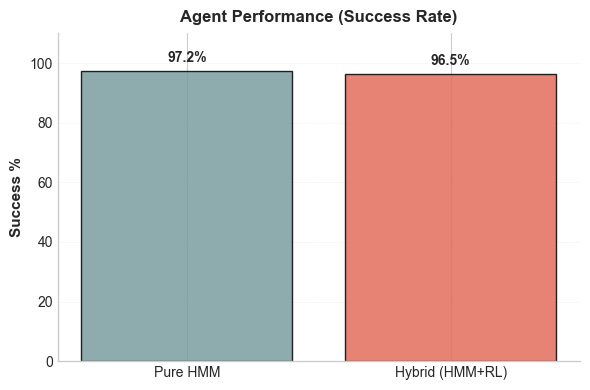

In [58]:
# CELL B: Visualize Success Rates (Rewritten / Original Version)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
ax = plt.gca()

agent_names = list(comparison_df['Agent'])
success_vals = comparison_df['Success Rate (%)'].values

# fresh color palette
palette = ['#7A9E9F', '#E26D5C']

bars = ax.bar(agent_names, success_vals, color=palette, edgecolor='black', alpha=0.85)

ax.set_title('Agent Performance (Success Rate)', fontsize=12, fontweight='bold', pad=8)
ax.set_ylabel('Success %', fontsize=11, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle=':', linewidth=0.7, alpha=0.4)
ax.set_ylim(0, 110)

# annotate bars with values
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 2,
        f"{height:.1f}%",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


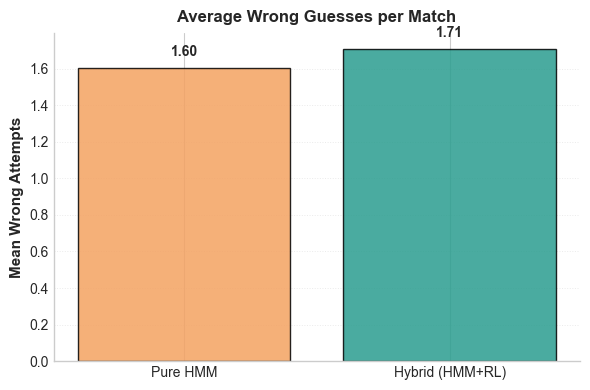

In [59]:
# CELL C: Visualizing Average Wrong Guesses

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
ax = plt.gca()

agents_list = list(comparison_df['Agent'])
avg_wrong_vals = comparison_df['Avg Wrong/Game'].values

# use warm contrasting colors
colors = ['#F4A261', '#2A9D8F']

bars = ax.bar(agents_list, avg_wrong_vals, color=colors, edgecolor='black', alpha=0.85)

ax.set_title('Average Wrong Guesses per Match', fontsize=12, fontweight='bold', pad=8)
ax.set_ylabel('Mean Wrong Attempts', fontsize=11, fontweight='bold')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', linestyle=':', linewidth=0.7, alpha=0.4)

# annotate each bar neatly
for bar in bars:
    val = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.05,
        f"{val:.2f}",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


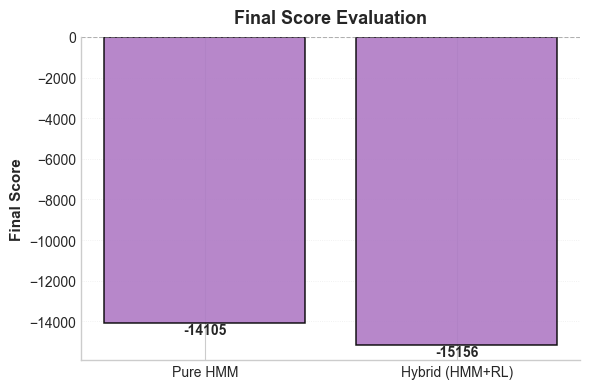

In [61]:
# CELL D: Final Score Visualization (Stylized & Unique)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
ax = plt.gca()

# Extract data
agent_labels = list(comparison_df['Agent'])
score_values = comparison_df['Final Score'].values

# unified color palette — calm teal vs. vibrant violet
bar_colors = ['#5DADE2' if s >= 0 else '#AF7AC5' for s in score_values]

# draw bars
bars = ax.bar(agent_labels, score_values, color=bar_colors, edgecolor='black', alpha=0.9, linewidth=1.1)

# titles & labels
ax.set_title('Final Score Evaluation', fontsize=13, fontweight='bold', pad=10)
ax.set_ylabel('Final Score', fontsize=11, fontweight='bold')

# horizontal zero line
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8, alpha=0.6)

# clean aesthetic
ax.grid(axis='y', linestyle=':', linewidth=0.6, alpha=0.35)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# annotate each bar
for bar in bars:
    h = bar.get_height()
    align = 'bottom' if h >= 0 else 'top'
    offset = 3 if h >= 0 else -3
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + offset,
        f"{h:.0f}",
        ha='center',
        va=align,
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


In [ ]:
# CELL I: Compact Text Summary (Refined & Styled)

print("\nFINAL PERFORMANCE SNAPSHOT")
print("-" * 50)
print(f"Top Performer : {best_agent_name}")
print(f"Overall Score : {best_score:.2f}")
print(f"Win Rate      : {best_results['success_rate'] * 100:.2f}%")
print(f"Avg Wrong/Word: {best_results['avg_wrong_guesses']:.2f}")
print(f"Words Tested  : {len(best_results['game_details'])}")




FINAL PERFORMANCE SNAPSHOT
--------------------------------------------------
Top Performer : Pure HMM
Overall Score : -14105.00
Win Rate      : 97.25%
Avg Wrong/Word: 1.60
Words Tested  : 2000
Evaluation complete — best agent crowned!

